In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
import sys
sys.path.append('/content/')

from wildfire_lstm import WildfireLSTM
from wildfire_vae import WildfireVAE
from wildfire_da import DAwrapper
import preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_img(data, ts, title):
    fig, axes = plt.subplots(1, len(ts), figsize=[20, 8])
    
    for i, ax in enumerate(axes.ravel()):
        im = ax.imshow(data[ts[i]])
        ax.set_title(str(ts[i]))
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        
        fig.colorbar(im, cax=cax)

    
    fig.suptitle(title, fontsize=16)
    
    plt.show()

#### Load in the data

In [4]:
train, test, background, obs = preprocessing.load_data('/content/drive/MyDrive/')

## Objective 1: LSTM

In [5]:
x_train, y_train, x_test, y_test, background_lstm = preprocessing.reshape_data_for_lstm(train, test, background)

Shape of x_train:  (12500, 256, 256, 1)
Shape of y_train:  (12500, 256, 256, 1)
Shape of x_test:  (5000, 256, 256, 1)
Shape of y_test:  (5000, 256, 256, 1)
Shape of background:  (5, 256, 256, 1)


Shift the y_train dataset by 10 in order to train the model to predict time t+10 from time t

In [6]:
x_train_fnl, y_train_fnl, x_test_fnl, y_test_fnl, background_fnl = preprocessing.split_and_shift_datasets(x_train, y_train, x_test, y_test, background_lstm)

create final train data for LSTM
Shape of x_train_fnl: (125, 80, 2, 256, 256, 1)
Shape of y_train_fnl: (125, 80, 256, 256, 1)
create final test data for LSTM
Shape of x_test_fnl: (4980, 2, 256, 256, 1)
Shape of y_test_fnl: (4980, 256, 256, 1)
create final background data
Shape of back_fnl: (3, 2, 256, 256, 1)


##### NOTE: Choose one of the two cells below to run. The first will load our pretrained model, the next will train a new model, and will take ~20 minutes

In [ ]:
# Switch the below two lines if you would like to use the already trained model
lstm = WildfireLSTM(model_path='../models/LSTM_V4.keras')

In [7]:
lstm = WildfireLSTM()
lstm.build_LSTM_model()
lstm.train_LSTM_model(x_train_fnl=x_train_fnl, y_train_fnl=y_train_fnl)

Training on simulation 1 out of 125
Epoch 1/10
4/4 [==============================] - 16s 101ms/step - loss: 0.6869 - accuracy: 0.7498
Epoch 2/10
4/4 [==============================] - 0s 100ms/step - loss: 0.6696 - accuracy: 0.9996
Epoch 3/10
4/4 [==============================] - 0s 101ms/step - loss: 0.6521 - accuracy: 0.9995
Epoch 4/10
4/4 [==============================] - 0s 100ms/step - loss: 0.6344 - accuracy: 0.9995
Epoch 5/10
4/4 [==============================] - 0s 100ms/step - loss: 0.6163 - accuracy: 0.9995
Epoch 6/10
4/4 [==============================] - 0s 100ms/step - loss: 0.5979 - accuracy: 0.9996
Epoch 7/10
4/4 [==============================] - 0s 100ms/step - loss: 0.5792 - accuracy: 0.9996
Epoch 8/10
4/4 [==============================] - 0s 101ms/step - loss: 0.5601 - accuracy: 0.9997
Epoch 9/10
4/4 [==============================] - 0s 100ms/step - loss: 0.5408 - accuracy: 0.9997
Epoch 10/10
4/4 [==============================] - 0s 100ms/step - loss: 0.5213 -

### Generate predictions on the background data

In [8]:
lstm_predictions = lstm.model.predict(background_fnl)

1/1 [==============================] - 0s 397ms/step


The LSTM takes in 2 images, for t = 0,10, and predicts the image at t=20.

For example, we use background images at t = 59, 69, 79, 89, and predict the images at t = 79, 89, 99

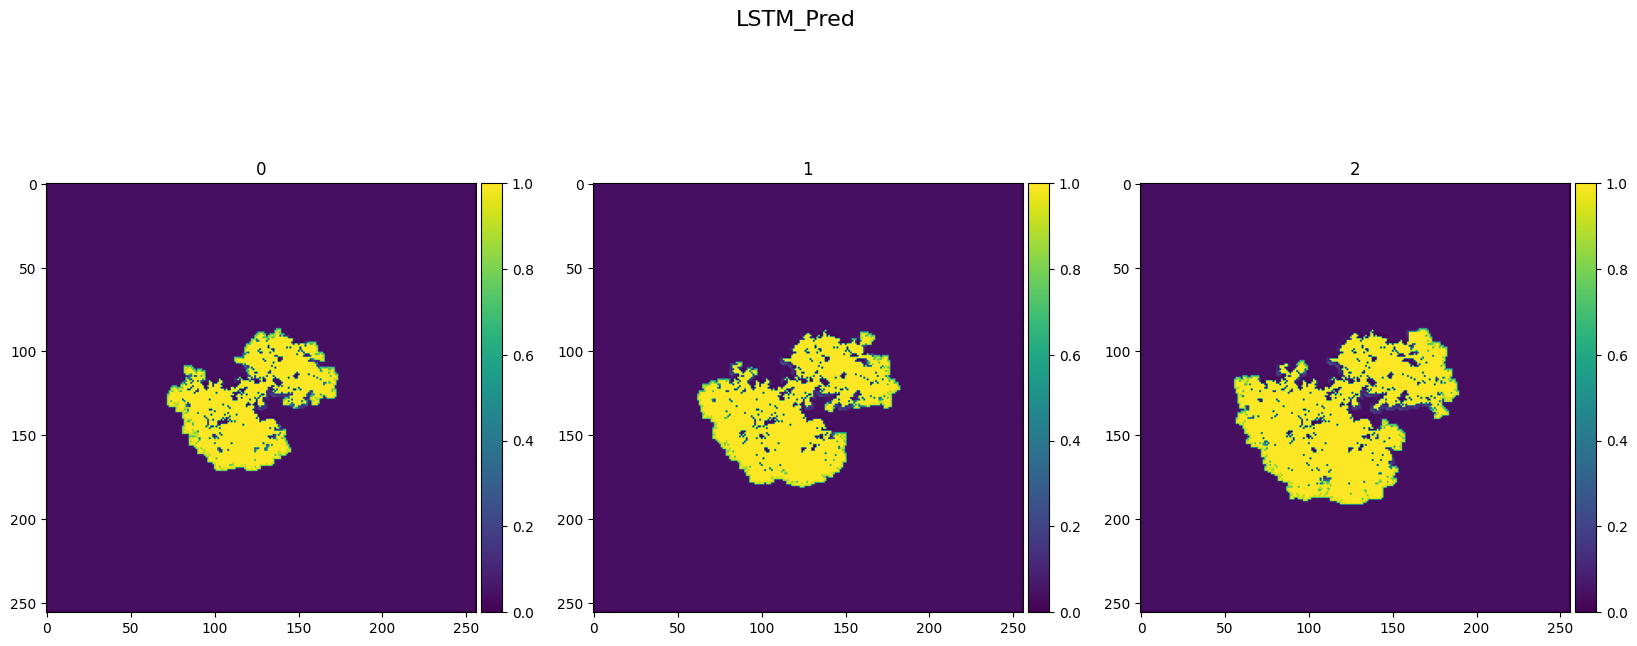

In [44]:
plot_img(lstm_predictions,[0,1,2],'LSTM_Pred')

### Calculate MSE with Satellite data

In [10]:

mse_obs = mean_squared_error(lstm_predictions.reshape(3,-1),obs[2:].reshape(3,-1))

In [11]:
mse_obs

0.0804207614653275

## Objective 2: VAE

In [12]:
x_train, y_train, x_test, y_test = preprocessing.reshape_data_for_vae(train, test)

Shape of x_train:  (11250, 256, 256)
Shape of y_train:  (11250, 256, 256)
Shape of x_test:  (4500, 256, 256)
Shape of y_test:  (4500, 256, 256)


In [13]:
vae = WildfireVAE()

Epoch 1/30
250/250 [==============================] - 18s 41ms/step - loss: 23302.0508 - val_loss: 32850.6797 - lr: 1.0000e-04
Epoch 2/30
250/250 [==============================] - 9s 35ms/step - loss: 8885.1436 - val_loss: 11133.8047 - lr: 1.0000e-04
Epoch 3/30
250/250 [==============================] - 9s 35ms/step - loss: 5350.1895 - val_loss: 5003.2529 - lr: 1.0000e-04
Epoch 4/30
250/250 [==============================] - 9s 35ms/step - loss: 3731.7646 - val_loss: 3411.8201 - lr: 1.0000e-04
Epoch 5/30
250/250 [==============================] - 9s 35ms/step - loss: 2940.7351 - val_loss: 2775.2166 - lr: 1.0000e-04
Epoch 6/30
250/250 [==============================] - 9s 35ms/step - loss: 2493.5063 - val_loss: 2352.6392 - lr: 1.0000e-04
Epoch 7/30
250/250 [==============================] - 9s 35ms/step - loss: 2197.4895 - val_loss: 2103.2561 - lr: 1.0000e-04
Epoch 8/30
250/250 [==============================] - 9s 35ms/step - loss: 2008.1278 - val_loss: 1938.8844 - lr: 1.0000e-04
Epoc

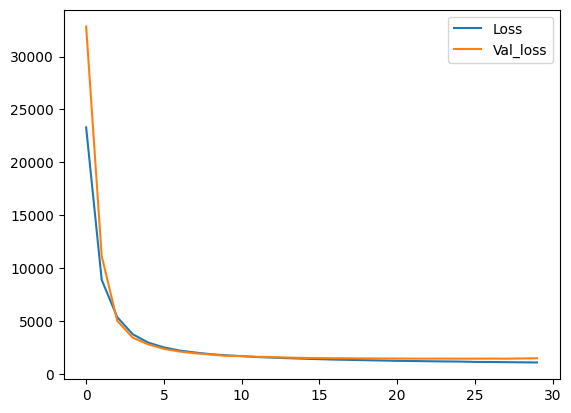

In [14]:
vae.train(x_train, y_train, x_test, y_test)

the VAE takes in t = 0 to predict t = 10

1/1 [==============================] - 0s 23ms/step


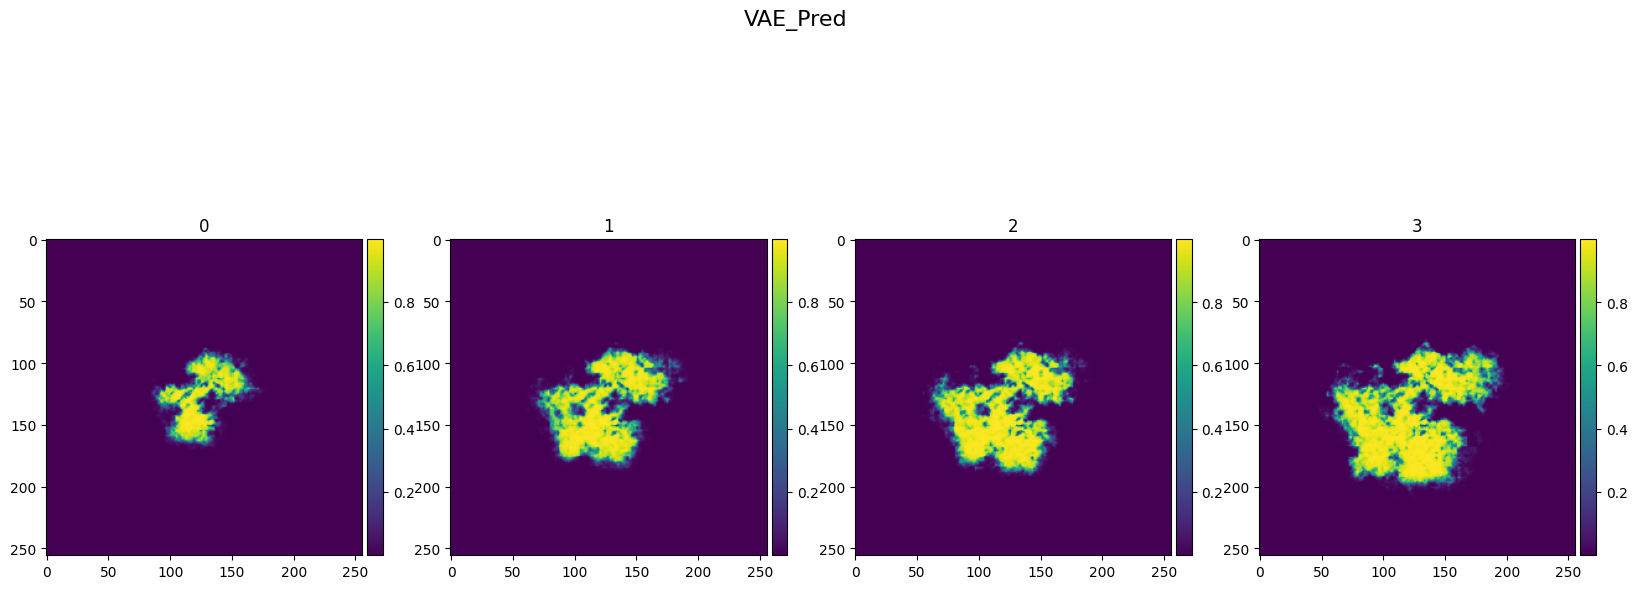

In [45]:
vae_predictions = vae.predict(background)

plot_img(vae_predictions, [0, 1, 2, 3],'VAE_Pred')

In [16]:
mse = mean_squared_error(vae_predictions.reshape(-1, 256*256), obs.reshape(-1, 256*256))
mse

0.0721871667716694

In [17]:
vae_predictions.shape

(5, 256, 256, 1)

## Objective 3: Data Assimilation

### LSTM DA

In [18]:
lstm_da_wrapper = DAwrapper(lstm_predictions, obs[2:])

In [19]:
lstm_da_wrapper.compress(0.95)

In [20]:
lstm_da_wrapper.assimilate()

In [21]:
lstm_recon = lstm_da_wrapper.reconstruct(lstm_da_wrapper.predictions_assimilated)

In [22]:
obs_lstm = obs[2:]
lstm_obs_flattened = np.reshape(obs_lstm, (obs_lstm.shape[0], obs_lstm.shape[1] * obs_lstm.shape[2]))
lstm_obs_flattened.shape

(3, 65536)

In [23]:
mean_squared_error(lstm_recon, lstm_obs_flattened)

0.07061638970220471

In [24]:
lstm_recon = np.reshape(lstm_recon, (lstm_recon.shape[0], 256,256))

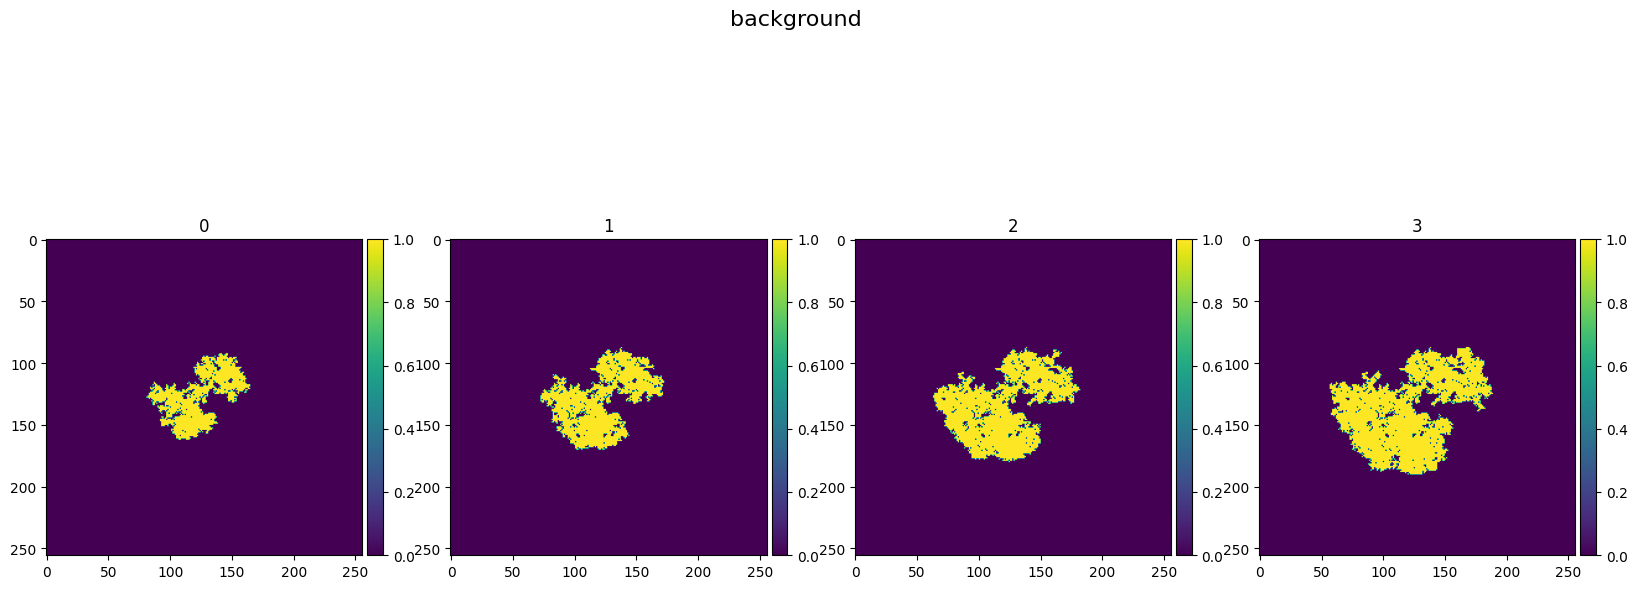

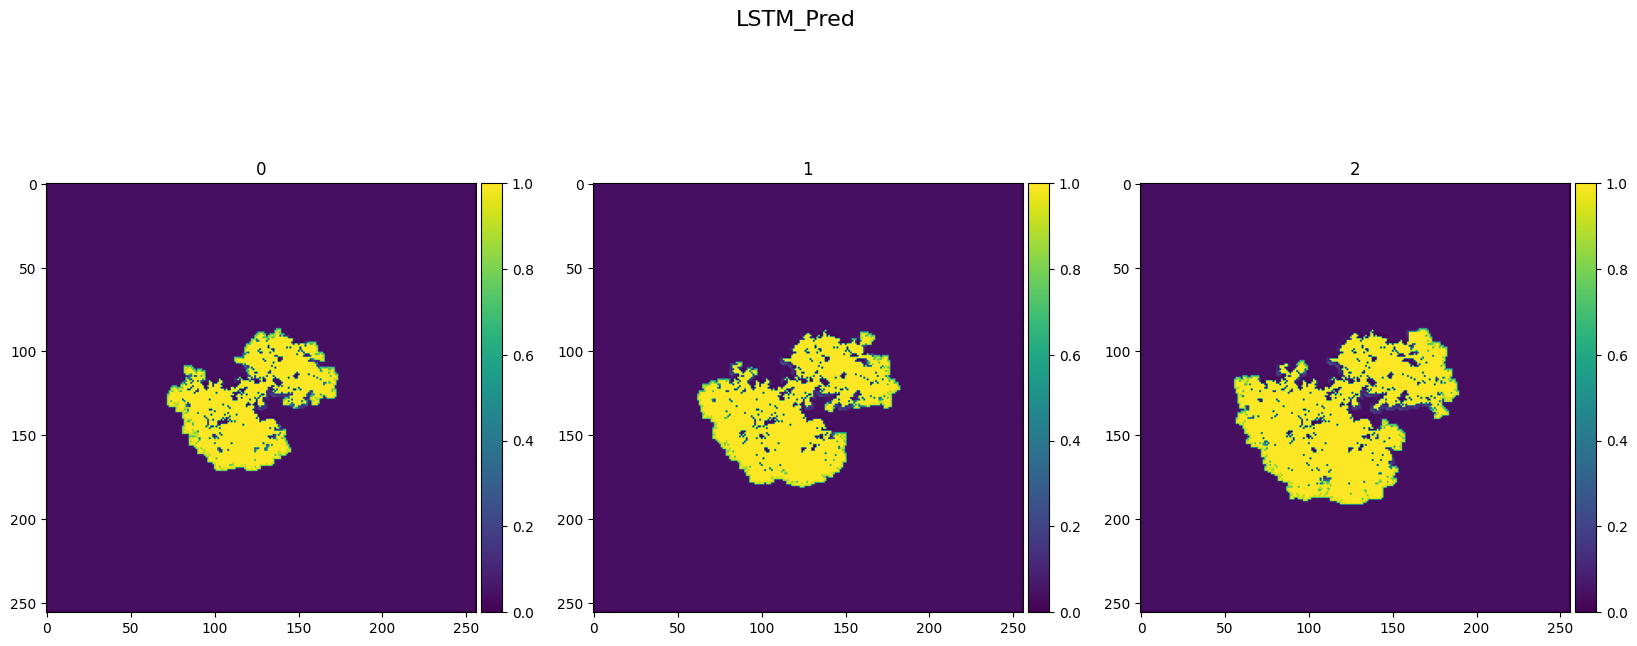

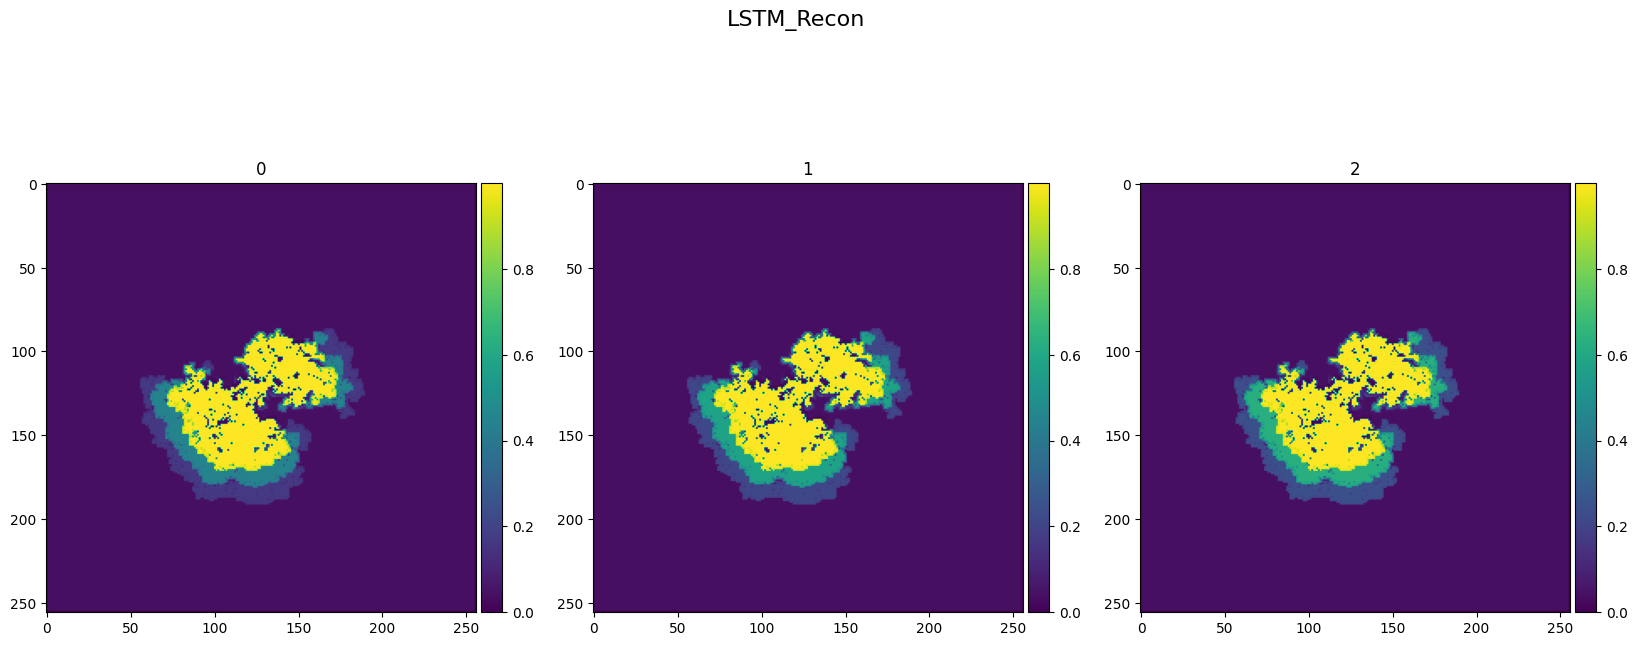

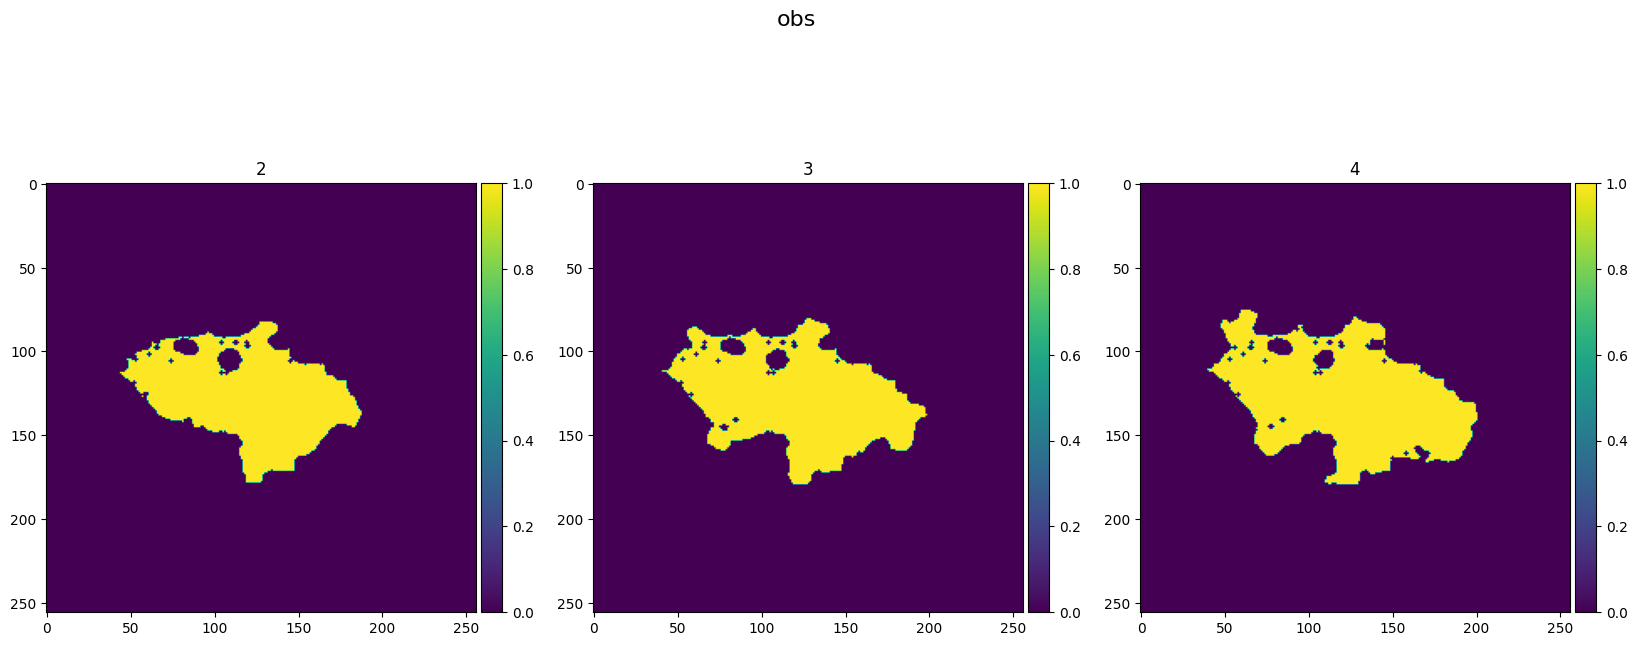

In [46]:
plot_img(background, [0,1,2,3],'background')
plot_img(lstm_predictions, [0,1,2],'LSTM_Pred')
plot_img(lstm_recon, [0,1,2],'LSTM_Recon')
plot_img(obs, [2,3,4],'obs') # plot last 3 satellite images

### VAE DA

In [26]:
vae_da_wrapper = DAwrapper(vae_predictions, obs)

In [27]:
vae_da_wrapper.compress(0.95)

In [28]:
vae_da_wrapper.assimilate()

In [29]:
recon = vae_da_wrapper.reconstruct(vae_da_wrapper.predictions_assimilated)

In [30]:
obs_flattened = np.reshape(obs, (obs.shape[0], obs.shape[1] * obs.shape[2]))

In [31]:
mean_squared_error(recon, obs_flattened)

0.06040934249910967

In [32]:
recon = np.reshape(recon, (recon.shape[0], 256,256))

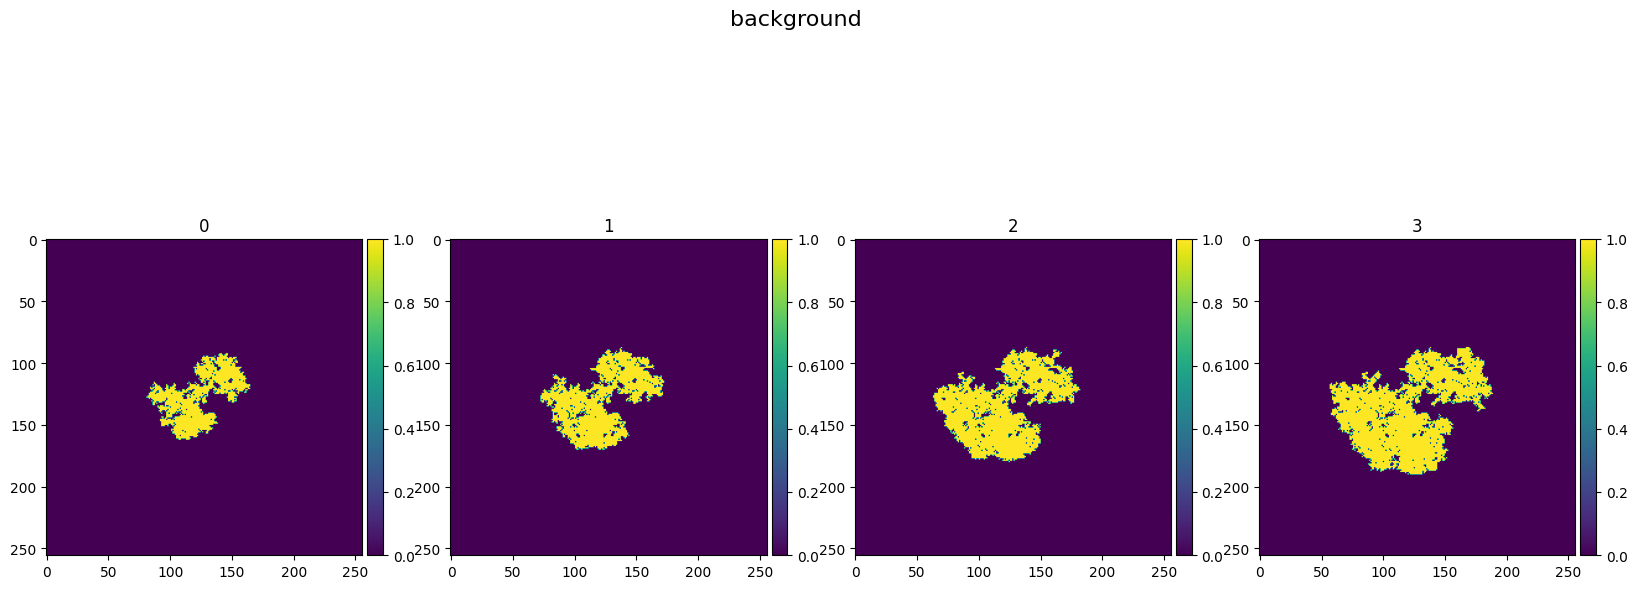

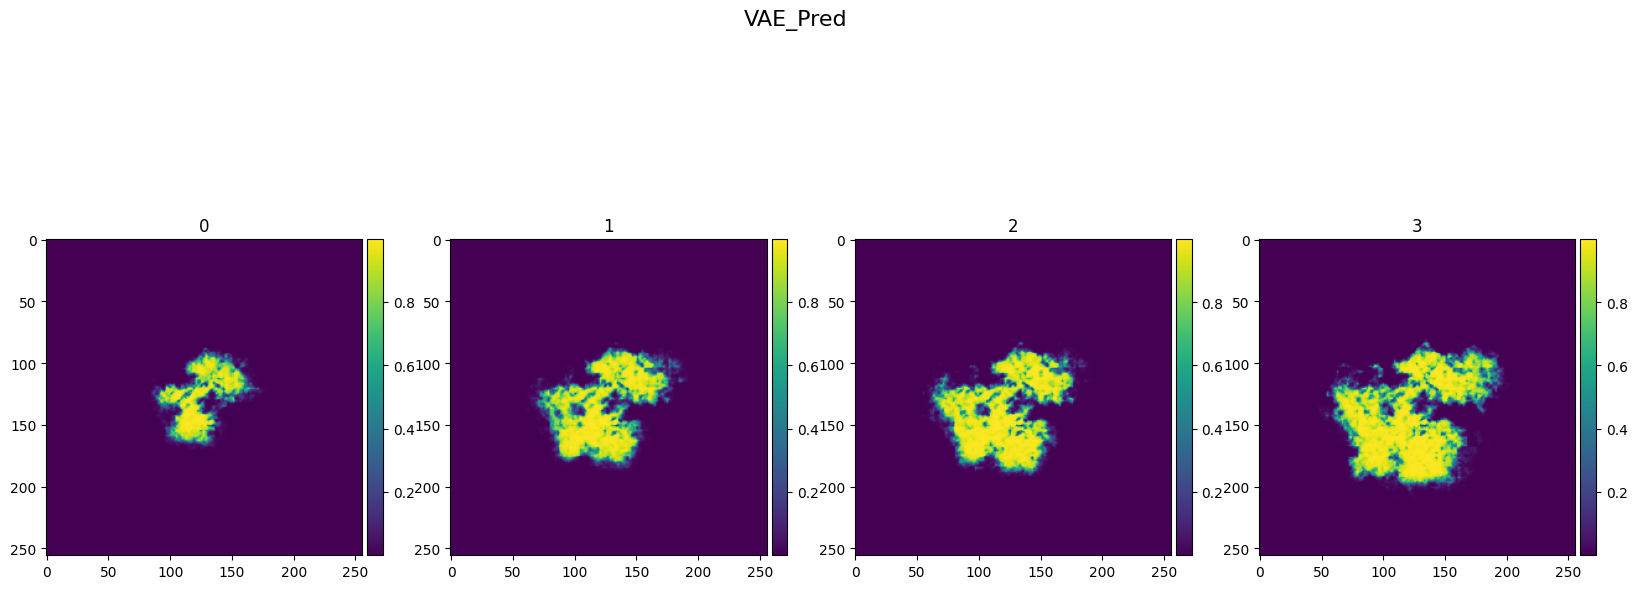

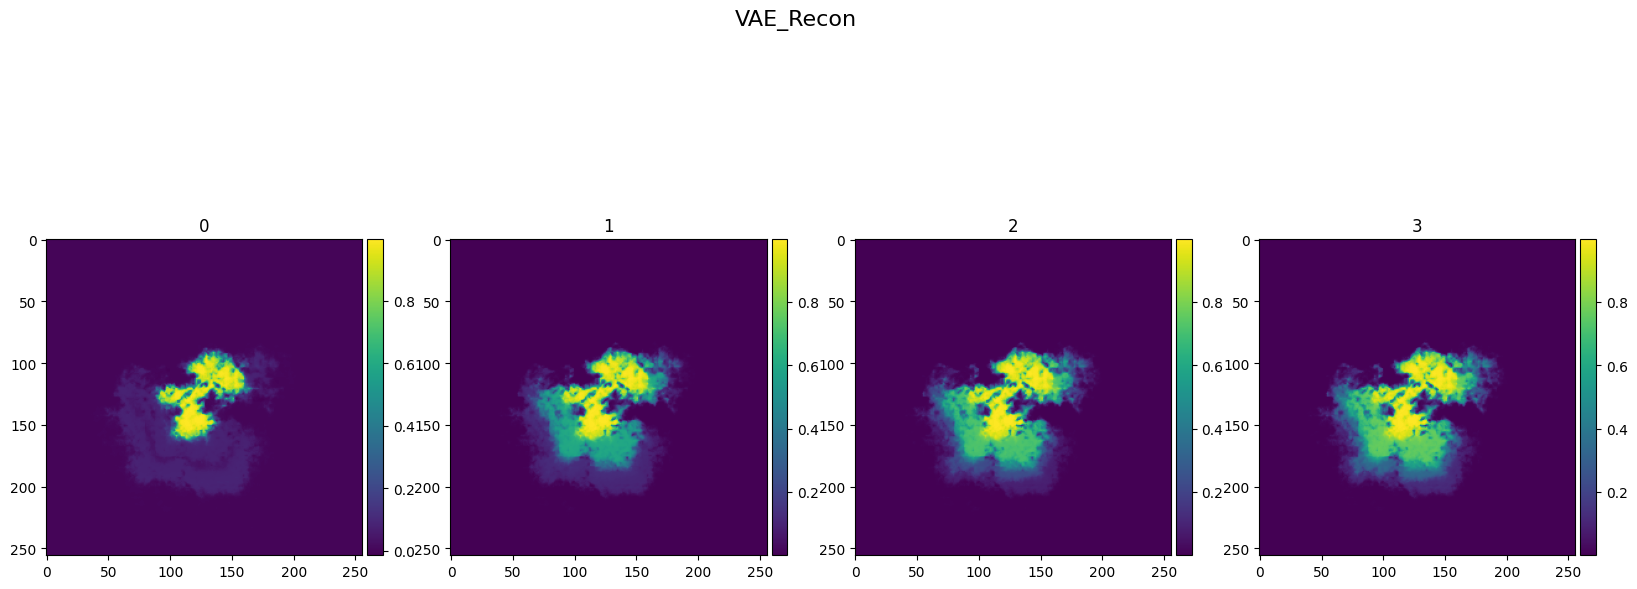

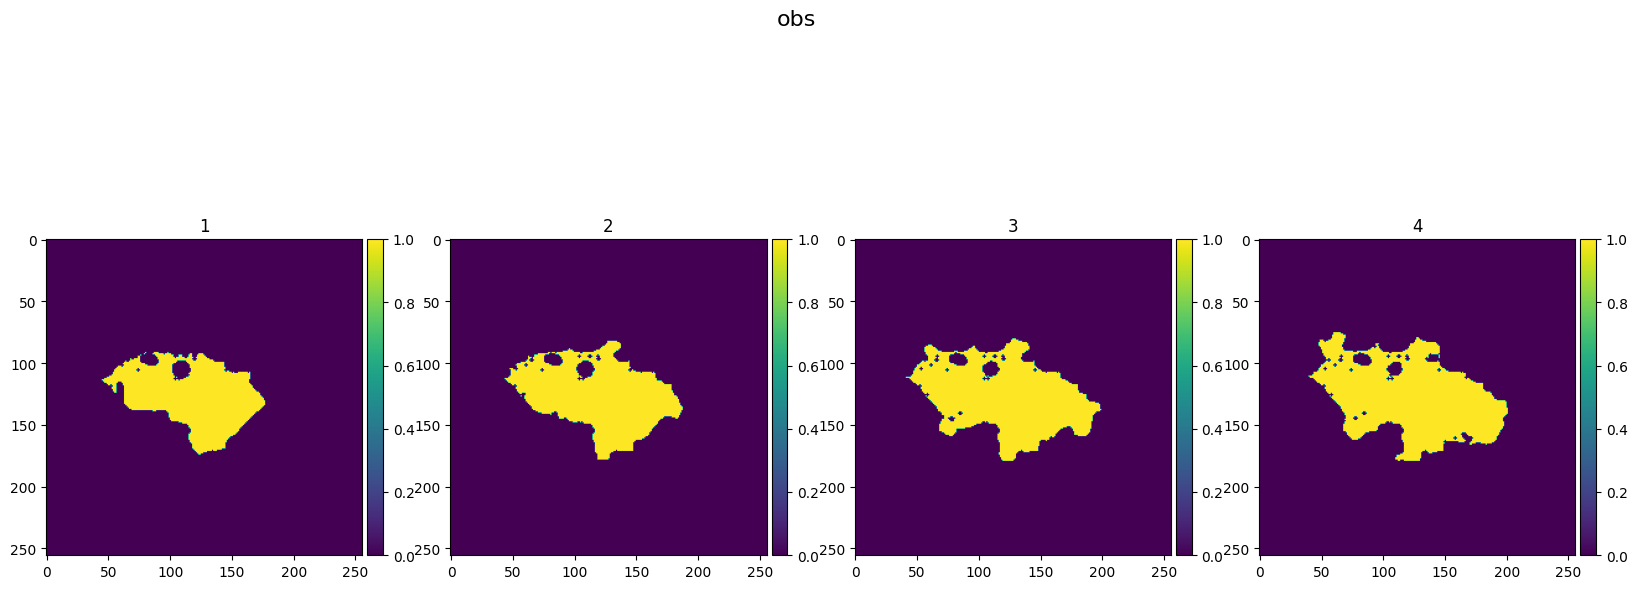

In [47]:
plot_img(background, [0,1,2,3],'background')
plot_img(vae_predictions, [0,1,2,3],'VAE_Pred')
plot_img(recon, [0,1,2,3],'VAE_Recon')
plot_img(obs, [1,2,3,4],'obs')